### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import shutil
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import random
import cv2
import h5py
import pickle
import imutils
import glob
import os
import urllib.request
from utils import *
from tqdm import tqdm

from keras.models import Sequential, Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation
from keras.layers import UpSampling2D, BatchNormalization, Flatten, Dense, GlobalMaxPooling2D
from keras.layers.core import Dropout, Reshape
from keras.layers.merge import Concatenate
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.optimizers import RMSprop, Adam, SGD

seed = 0
np.random.seed(seed)

Using TensorFlow backend.
/home/arsh/anaconda3/envs/deepLearn/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Download and read data

In [2]:
train = pd.read_csv('./Data/Share/myntra_train_dataset.csv')

In [3]:
faulty = []
for url in tqdm(train['Link_to_the_image'].dropna().drop_duplicates()):
    name = url[url.rfind('/')+1:]
    if os.path.exists('./Data/Train/'+name):
        continue
    try:
        urllib.request.urlretrieve(url, './Data/Train/'+name)
    except:
        faulty.append(url)

In [4]:
test = pd.read_csv('./Data/Share/myntra_test.csv')

In [5]:
faulty_test = []
for url in tqdm(test['Link_to_the_image'].dropna().drop_duplicates()):
    name = url[url.rfind('/')+1:]
    if os.path.exists('./Data/Test/'+name):
        continue
    try:
        urllib.request.urlretrieve(url, './Data/Test/'+name)
    except:
        faulty_test.append(url)

### Extract T-shirt

In [6]:
def boundingBox(edges, im):
    gray = edges.astype('uint8')
    im_h = gray.shape[0]
    im_w = gray.shape[1]
    cnts = cv2.findContours(gray,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
     
    x_l, y_l, x_r, y_r = [], [], [], []
    
    # loop over the digit area candidates
    for c in cnts:
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        
        x_l.append(x)
        y_l.append(y)
        x_r.append(x+w)
        y_r.append(y+h)
        
    
    # Getting the outer most bounding box
    x_l = min(x_l)
    y_l = min(y_l)
    x_r = max(x_r)
    y_r = max(y_r)
        
    return im[y_l:y_r, x_l:x_r, :]

In [7]:
def extractTshirt(im):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    v = np.median(gray)
    sigma = 0.33

    #---- apply optimal Canny edge detection using the computed median----
    lower_thresh = int(max(0, (1.0 - sigma) * v))
    upper_thresh = int(min(255, (1.0 + sigma) * v))
    edges = cv2.Canny(blur, lower_thresh, upper_thresh)
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.morphologyEx(edges, cv2.MORPH_DILATE, kernel)
    bounded = boundingBox(dilated, im)
    if bounded.shape[0]<1250:
        bounded = bounded
    else:
        height = bounded.shape[0]
        width = bounded.shape[1]
        bounded = bounded[int(1.3*height//4):int(3.5*(height//4)), :, :]
    return bounded

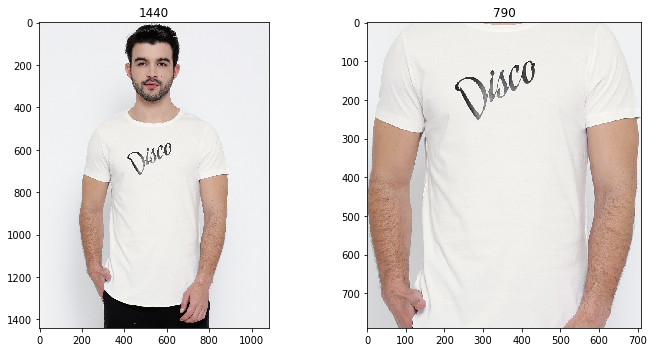

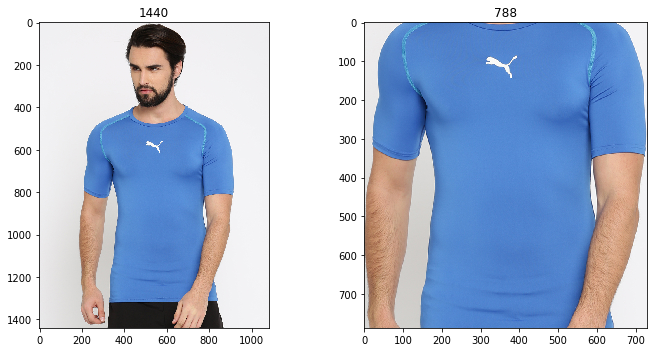

In [8]:
for im in np.random.choice(glob.glob('./Data/Train/*'), 2):
    im = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title(im.shape[0])
    plt.imshow(im)
    plt.subplot(1, 2, 2)
    bounded = extractTshirt(im)
    plt.title(bounded.shape[0])
    plt.imshow(bounded)
    plt.tight_layout()
    plt.show()

In [9]:
dims = []
for im_path in tqdm(glob.glob('./Data/Train/*')):
    im = cv2.imread(im_path)
    if im is not None:
        out_file = './Data/Train_cleaned_w_arms/'+im_path[im_path.rfind('/')+1:im_path.rfind('.')]+'.jpg'
        if not os.path.exists(out_file):
            try:
                im = extractTshirt(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
                cv2.imwrite(out_file, cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
                dims.append(im.shape)
            except ValueError:
                pass

In [10]:
dims_test = []
for im_path in tqdm(glob.glob('./Data/Test/*')):
    im = cv2.imread(im_path)
    if im is not None:
        out_file = './Data/Test_cleaned_w_arms/'+im_path[im_path.rfind('/')+1:im_path.rfind('.')]+'.jpg'
        if not os.path.exists(out_file):
            im = extractTshirt(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
            cv2.imwrite(out_file, cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
            dims.append(im.shape)

### Keras Model

In [13]:
labels = pd.get_dummies(train['Sub_category'])
labels.index = train.Link_to_the_image.astype(str).map(lambda x : x[x.rfind('/')+1:x.rfind('.')]+'.jpg')

In [14]:
all_files = glob.glob('./Data/Train_cleaned_w_arms/*')
test_files = glob.glob('./Data/Test_cleaned_w_arms/*')

In [15]:
width = 75
height = 75
channels = 3

#### Training

In [16]:
x_im = np.empty((len(all_files), height, width, channels))
y_tr = np.empty((len(all_files), 24))
for idx, im_path in enumerate(tqdm(all_files)):
    im = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (width, height), interpolation=cv2.INTER_AREA).reshape((height, width, channels))
    im_path = im_path[im_path.rfind('/')+1:]
    x_im[idx] = im
    y_tr[idx] = np.array(labels[labels.index==im_path].iloc[0].astype(np.float32))

In [17]:
with h5py.File('./Data/training_data_all_w_arms_col.h5', 'w') as hf:
    hf.create_dataset("x_im",  data=x_im, maxshape=(None, height, width, channels))
    hf.create_dataset("labels",  data=y_tr, maxshape=(None, 24))

In [18]:
with h5py.File('./Data/training_data_all_w_arms_col.h5', 'r') as hf:
    x_im = hf['x_im'][:]
    y_tr = hf['labels'][:]

#### Online Test

In [20]:
x_im_test = np.empty((len(test_files), height, width, channels))
link_test = []
for idx, im_path in enumerate(tqdm(test_files)):
    im = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (width, height), interpolation=cv2.INTER_AREA).reshape((height, width, channels))
    im_path = im_path[im_path.rfind('/')+1:]
    x_im_test[idx] = im
    link_test.append(im_path)

In [21]:
with h5py.File('./Data/test_data_w_arms_col.h5', 'w') as hf:
    hf.create_dataset("x_im",  data=x_im_test, maxshape=(None, height, width, channels))
pickle.dump(link_test, open('./Data/test_data_w_arms_col_links.pickle', 'wb'))

In [22]:
with h5py.File('./Data/test_data_w_arms_col.h5', 'r') as hf:
    x_im_test = preprocess_input(hf['x_im'][:])
link_test = pickle.load(open('./Data/test_data_w_arms_col_links.pickle', 'rb'))

In [23]:
x_test = x_im_test

In [40]:
def get_model():
    input_ = Input(shape=(height, width, channels), name="X_1")
    
    # Layers 1+2
    out = Conv2D(9, (3, 3), padding='valid')(input_)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Conv2D(18, (3, 3), padding='valid')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D((2, 2), strides=(2, 2))(out)
    out = Dropout(0.1)(out)
    
    # Layers 2+3
    out = Conv2D(36, (3, 3), padding='valid')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Conv2D(72, (3, 3), padding='valid')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D((2, 2), strides=(2, 2))(out)
#     out = Dropout(0.1)(out)

    # Layer 4
    out = Conv2D(144, (2, 2), padding='valid')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D((2, 2), strides=(2, 2))(out)
#     out = Dropout(0.1)(out)
    
    # Layer 5
    out = Conv2D(256, (2, 2), padding='valid')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D((2, 2), strides=(2, 2))(out)
#     out = Dropout(0.1)(out)
    
    out = Flatten()(out)
    
    # FCs 1+2+3
    out = Dense(1024, activation='relu')(out)
    out = Dropout(0.5)(out)
    out = Dense(196, activation='relu')(out)
    out = Dropout(0.1)(out)
    out = Dense(24, activation="softmax")(out)

    model = Model(input_, out)
    optimizer = Adam()
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

model = get_model()

### KFold

In [29]:
kfold = 5
kfold_scores = []

results = []
completed = [0]
sss = KFold(n_splits=kfold, random_state=0)
for i, (train_index, val_index) in enumerate(sss.split(all_files)):
    
    with h5py.File('./Data/training_data_all_w_arms_col.h5', 'r') as hf:
        train_index = list(train_index)
        val_index = list(val_index)
        x_im_tr = hf['x_im'][train_index]/255.0
        x_im_val = hf['x_im'][val_index]/255.0
        y_tr = hf['labels'][train_index]
        y_val = hf['labels'][val_index]

    X_train_KF, X_valid_KF = x_im_tr, x_im_val
    y_train_KF, y_valid_KF = y_tr, y_val

    # Train
    model = get_model()
    epochs = 300
    batch_size = 64

    callbacks = [EarlyStopping(monitor='val_loss',
                               patience=19,
                               verbose=1,
                               min_delta=1e-4),
                 ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.3,
                                   patience=6,
                                   verbose=1,
                                   epsilon=1e-4),
                 ModelCheckpoint(monitor='val_loss',
                                 filepath='keras_models/kfold_w_arms_col/best_weights_'+str(i+1)+'.hdf5',
                                 save_best_only=True,
                                 save_weights_only=True)]

    model.fit(X_train_KF, y_train_KF, validation_data=(X_valid_KF, y_valid_KF), epochs=epochs, 
              batch_size=batch_size, callbacks=callbacks)
    model.load_weights('keras_models/kfold_w_arms_col/best_weights_'+str(i+1)+'.hdf5')

    # Predict
    preds_val = np.argmax(model.predict(X_valid_KF), 1)
    preds_test = model.predict(x_test)
    
    best_prec1 = sum(np.argmax(y_valid_KF, 1)==preds_val)/len(preds_val)
    print('Val Score : %f' % (best_prec1))
    
    kfold_scores.append(best_prec1)
    results.append(preds_test)
    print('##################################################')

Train on 54921 samples, validate on 13731 samples
Epoch 1/300
54921/54921 [==============================] - 191s - loss: 1.8825 - acc: 0.4659 - val_loss: 1.5828 - val_acc: 0.5692
Epoch 2/300
54921/54921 [==============================] - 186s - loss: 1.4798 - acc: 0.5866 - val_loss: 1.4918 - val_acc: 0.5837
Epoch 3/300
54921/54921 [==============================] - 186s - loss: 1.3750 - acc: 0.6135 - val_loss: 1.3661 - val_acc: 0.6143
Epoch 4/300
54921/54921 [==============================] - 187s - loss: 1.2980 - acc: 0.6310 - val_loss: 1.3682 - val_acc: 0.6230
Epoch 5/300
54921/54921 [==============================] - 188s - loss: 1.2307 - acc: 0.6475 - val_loss: 1.2672 - val_acc: 0.6402
Epoch 6/300
54921/54921 [==============================] - 188s - loss: 1.1590 - acc: 0.6651 - val_loss: 1.2510 - val_acc: 0.6474
Epoch 7/300
54921/54921 [==============================] - 190s - loss: 1.0923 - acc: 0.6818 - val_loss: 1.2271 - val_acc: 0.6598
Epoch 8/300
54921/54921 [===============

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/arsh/anaconda3/envs/deepLearn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-5bad350854db>", line 49, in <module>
    batch_size=batch_size, callbacks=callbacks)
  File "/home/arsh/anaconda3/envs/deepLearn/lib/python3.6/site-packages/keras/engine/training.py", line 1598, in fit
    validation_steps=validation_steps)
  File "/home/arsh/anaconda3/envs/deepLearn/lib/python3.6/site-packages/keras/engine/training.py", line 1183, in _fit_loop
    outs = f(ins_batch)
  File "/home/arsh/anaconda3/envs/deepLearn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2273, in __call__
    **self.session_kwargs)
  File "/home/arsh/anaconda3/envs/deepLearn/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 889, in run
    run_metadata_ptr)
  File "/home/arsh/anaconda3/envs/deepLearn/lib/python3.6/

KeyboardInterrupt: 

#### Prepare output file

In [23]:
label_list = list(labels.columns)

In [24]:
label_map_dict= {i.lower() : i for i in label_list}

In [44]:
combined_results = np.argmax(np.array(results).mean(axis=0), 1)
combined_results = [label_list[i] for i in combined_results]

In [45]:
b = set([i.lower() for i in labels.columns])
test['leakage_labs'] = test.Link_to_the_image.astype(str).map(lambda x :
                                                      list(set(x[x.rfind('/')+1:x.rfind('.')].lower() \
                                                      .split('-')).intersection(b)))
test['leakage_labs'] = test['leakage_labs'].map(lambda x : label_map_dict[x[0]] if len(x) > 0 else np.NaN)

In [46]:
test['Key'] = test.Link_to_the_image.astype(str).map(lambda x : x[x.rfind('/')+1:x.rfind('.')]+'.jpg')

In [47]:
test['prediction'] = test['Key'].map(lambda x : combined_results[link_test.index(x)] 
                                     if x in link_test else '')

In [48]:
test['Sub_category'] = test['leakage_labs'].fillna(test['prediction'])

In [31]:
test = test.drop(['Key', 'leakage_labs', 'prediction'], axis=1)

In [33]:
test = test.fillna('')
test.to_csv('./Submissions/Sub_1_Apr_v2.csv', index=False)

In [32]:
{x:combined_results.count(x) for x in combined_results}

{'Abstract': 212,
 'Biker': 2,
 'Camouflage': 29,
 'Checked': 28,
 'Colourblocked': 434,
 'Conversational': 162,
 'Floral': 256,
 'Geometric': 273,
 'Graphic': 1135,
 'Humour and Comic': 46,
 'People and Places': 136,
 'Self Design': 1,
 'Solid': 5893,
 'Sports': 1,
 'Sports and Team Jersey': 8,
 'Striped': 2344,
 'Superhero': 76,
 'Tie and Dye': 1,
 'Tribal': 7,
 'Typography': 3659,
 'Varsity': 15}